# Implement names generator

Use architecture from Bengio et al

In [2]:
import time
import random

import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# plt.style.use('classic')
plt.style.use('dark_background')

In [4]:
torch.cuda.is_available()

True

In [5]:
def move_to_device(tensors, device):
    new_tensors = [None] * len(tensors)
    with torch.no_grad():
        for idx, tensor in enumerate(tensors):
            new_tensors[idx] = tensor.to(device, copy=True)
    return new_tensors

### Prepare dataset

In [6]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
    random.shuffle(words)


In [7]:
block_size = 4

In [8]:
all_letters = set(sum((list(s) for s in words), []))

In [9]:
all_symbols = all_letters.union({'.'})
stoi = {'.': 0}
stoi.update({letter: idx for idx, letter in enumerate(all_letters, 1)})
itos = {idx: letter for letter, idx in stoi.items()}

# create dataset
X = list()
y = list()
for word in words:
    word = block_size * '.' + word + '.'
    for idx in range(block_size, len(word)):
        prev = word[(idx-block_size):idx]
        X.append(list(stoi[s] for s in prev))
        y.append(stoi[word[idx]])

X = torch.tensor(X)
y = torch.tensor(y)

In [10]:
def split_dataset(X, y):
    total_len = X.shape[0]
    
    n1 = int(0.8 * total_len)
    n2 = int(0.9 * total_len)

    return (X[:n1], y[:n1]), (X[n1:n2], y[n1:n2]), (X[n2:], y[n2:])

    # num_tr = round(0.6 * total_len)
    # num_val = round(0.2 * total_len)
    # num_test = total_len - num_tr - num_val
    # idx_tr, idx_val, idx_test = torch.utils.data.random_split(range(X.shape[0]), [num_tr, num_val, num_test])
    # return (X[idx_tr], y[idx_tr]), (X[idx_val], y[idx_val]), (X[idx_test], y[idx_test])

In [11]:
(Xtr, ytr), (Xval, yval), (Xtest, ytest) = split_dataset(X, y)

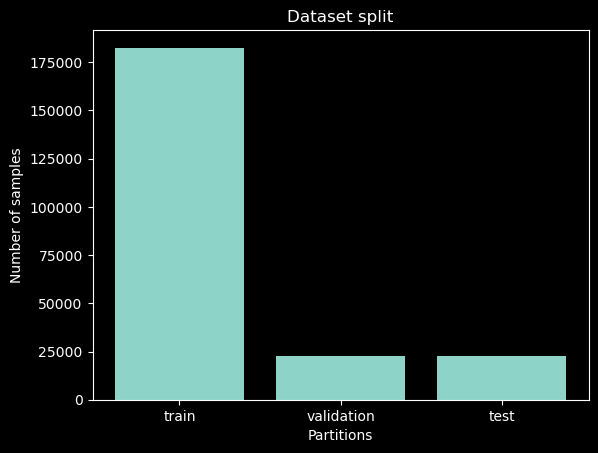

In [12]:
_, ax = plt.subplots(1, 1)
ax.set_title("Dataset split")
ax.set_xlabel("Partitions")
ax.set_ylabel("Number of samples")
ax.bar(['train', 'validation', 'test'], [len(Xtr), len(Xval), len(Xtest)])
plt.show()

### Define model class, loss and training loop

In [25]:
class Introspector:
    def __init__(self):
        self.first_layer_volume = None
        self.second_layer_activations = None
        self.third_layer_activations = None
        
        self.update_to_data_ratios = {}

In [26]:
class Embedding:
    def __init__(self, vocab_size, embedding_len):
        self.embedding_matr = torch.randn((vocab_size, embedding_len))

    def __call__(self, X):
        return self.embedding_matr[X]
    
    def parameters(self):
        return [self.embedding_matr]

class Flatten:
    def __call__(self, X):
        return X.view(X.shape[0], -1)
    def parameters(self):
        return []

class Linear:
    def __init__(self, prev_num_nodes, num_nodes):
        self.biases = torch.ones((num_nodes,)) * 0.0001
        self.weights = torch.randn(prev_num_nodes, num_nodes) / np.sqrt(prev_num_nodes)
    def __call__(self, X):
        return (X @ self.weights) + self.biases
    def parameters(self):
        return [self.biases, self.weights]

class Tanh:
    def __call__(self, X):
        return torch.tanh(X)
    def parameters(self):
        return []

class BatchNorm1D:
    def __init__(self, num_nodes):
        # Initialize parameters
        self.gain = torch.ones((1, num_nodes))
        self.bias = torch.zeros((1, num_nodes))
        # Initialize buffers
        self.running_mean = torch.zeros((1, num_nodes))
        self.running_var = torch.ones((1, num_nodes))
        # Other
        self.training = True
        self.momentum = 0.1
    def __call__(self, X):
        if self.training:
            batch_mean = X.mean(axis=0, keepdim=True)
            batch_var = X.var(axis=0, keepdim=True)
            
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
            
            normalized_X = (X - batch_mean) / torch.sqrt(batch_var)

            return self.gain * normalized_X + self.bias
        else:
            normalized_X = (X - self.running_mean) / np.sqrt(self.running_var)
            return self.gain * normalized_X + self.bias
    def parameters(self):
        return [self.bias, self.gain]

In [27]:
class Model:
    def __init__(self):
        # HPs
        self.embeddings_len = 15
        self.hidden_nodes1 = 400

        # Initialize layers
        self.layers = [
            Embedding(len(all_symbols), self.embeddings_len),
            Flatten(),
            Linear(block_size * self.embeddings_len, self.hidden_nodes1), BatchNorm1D(self.hidden_nodes1), Tanh(),
            Linear(self.hidden_nodes1, len(all_symbols))
        ]
        
        self.layers[2].weights *= 5 / 3
        self.layers[-1].weights *= 0.01
        
        for layer in self.layers:
            for parameter in layer.parameters():
                parameter.requires_grad = True

        # Other
        self.introspector = Introspector()
        self.training = True

    def create_preds(self, X):
        self.layers[3].training = self.training
        
        for layer in self.layers[:5]:
            X = layer(X)

        self.introspector.second_layer_activations = X.clone()

        for layer in self.layers[5:]:
            X = layer(X)

        probs = torch.softmax(X, 1)

        self.introspector.third_layer_activations = probs.clone()

        return probs

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def move_to_device(self, device):
        parameters = move_to_device(self.parameters(), device)
        for p in parameters:
            p.requires_grad = True
        self.C, self.biases1, self.weights1, self.biases2, self.weights2 = parameters


In [28]:
def create_loss(predictions, actual):
    return - predictions[range(len(predictions)), actual].log().mean()


In [41]:
def training_loop(model: Model, num_iters, batch_size, lr):
    start_ts = time.time()
    
    print(f"Iter #0", )
    with torch.no_grad():
        train_loss = create_loss(model.create_preds(Xtr), ytr).item()
        val_loss = create_loss(model.create_preds(Xval), yval).item()
    print(f"\ttrain_loss = {train_loss:.2f}")
    print(f"\tval_loss = {val_loss:.2f}\n")

    for num_iter in range(num_iters):
        # get batch
        indices = torch.randint(0, len(Xtr) - 1, (batch_size,))
        batch_X = Xtr[indices]
        batch_y = ytr[indices]
        # batch_X = Xtr
        # batch_y = ytr
        
        # calculate loss
        loss = create_loss(model.create_preds(batch_X), batch_y)

        # zerograd
        for parameter_tensor in model.parameters():
            parameter_tensor.grad = None

        # backprop
        loss.backward()

        # update weights
        ratios = model.introspector.update_to_data_ratios
        for param_idx, parameter_tensor in enumerate(model.parameters()):
            if parameter_tensor.ndim == 2:
                ratio = (lr * parameter_tensor.grad).std() / parameter_tensor.data.std()
                if param_idx in ratios:
                    ratios[param_idx].append(ratio)
                else:
                    ratios[param_idx] = [ratio]
            parameter_tensor.data -= lr * parameter_tensor.grad

        # display train and validation losses
        if ((num_iter + 1) % 10_000) == 0:
            print(f"Iter #{num_iter+1}", )
            model.training = False
            with torch.no_grad():
                train_loss = create_loss(model.create_preds(Xtr), ytr).item()
                val_loss = create_loss(model.create_preds(Xval), yval).item()
            model.training = True
            print(f"\ttrain_loss = {train_loss:.2f}")
            print(f"\tval_loss = {val_loss:.2f}\n")

        # if time.time() - start_ts >= max_time:
        #     break


### Train the model

In [56]:
# Create model
model = Model()

# Move to device
# device = torch.device('cuda', 0)
device = torch.device('cpu')
# model.move_to_device(device)
# Xtr, ytr, Xval, yval = move_to_device(
#     [
#         Xtr, ytr, Xval, yval
#     ],
#     device
# )

In [61]:
model.training = True
batch_size = 32

lr = 0.05
training_loop(model, 50_000, batch_size, lr)

# lr = 0.01
# training_loop(model, 50_000, batch_size, lr)

# lr = 0.001
# training_loop(model, 50_000, batch_size, lr)

# lr = 0.0001
# training_loop(model, 50_000, batch_size, lr)

Iter #0
	train_loss = 2.13
	val_loss = 2.14

Iter #10000
	train_loss = 2.12
	val_loss = 2.15

Iter #20000
	train_loss = 2.10
	val_loss = 2.13

Iter #30000
	train_loss = 2.08
	val_loss = 2.12

Iter #40000
	train_loss = 2.05
	val_loss = 2.10

Iter #50000
	train_loss = 2.04
	val_loss = 2.10



The recommended update to data ratio, as said be Andrej Karpathy, is 1e-3

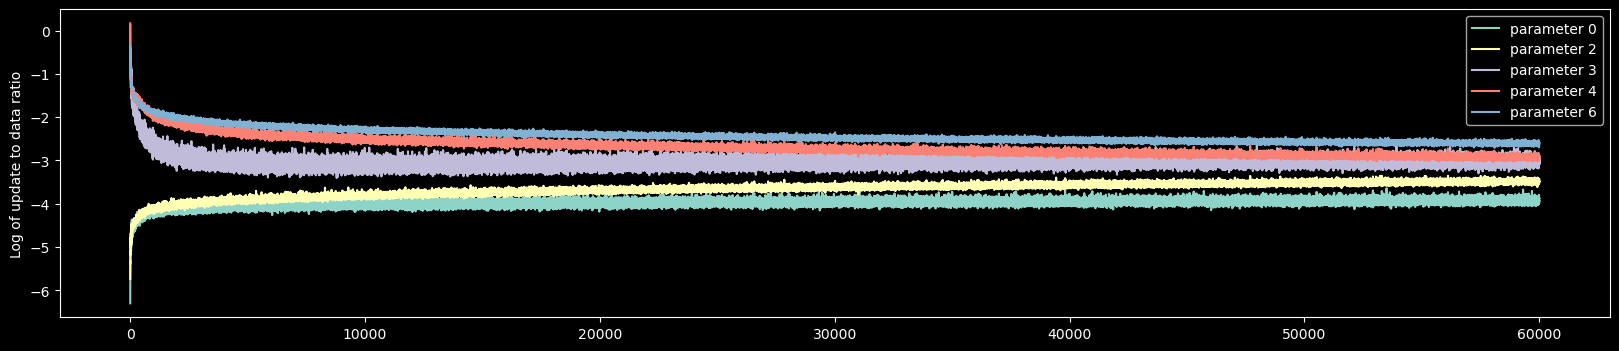

In [60]:
ratios = model.introspector.update_to_data_ratios

plt.figure(figsize=(20, 4))
for param_idx in ratios:
    plt.plot([np.log10(ratio) for ratio in ratios[param_idx]], label=f"parameter {param_idx}")

plt.ylabel('Log of update to data ratio')
plt.legend()
plt.show()

Training and validation losses:

In [134]:
model.training = False
with torch.no_grad():
    train_loss = create_loss(model.create_preds(Xtr), ytr)
    val_loss = create_loss(model.create_preds(Xval), yval)
print(f"Training loss: {train_loss.item():.2f}")
print(f"Validation loss: {val_loss.item():.2f}")

Training loss: 1.95
Validation loss: 2.05


### Demonstrate performance qualitatively

10 names generated by the trained model

In [136]:
model.training = False
for _ in range(10):
    context = block_size * [stoi['.']]
    name = []
    next_char = None
    while next_char != '.':
        probs = model.create_preds(torch.tensor([context], dtype=torch.int))
        next_idx = torch.multinomial(probs, 1).item()
        next_char = itos[next_idx]
        name.append(next_char)
        context = context[1:] + [next_idx]
    print("".join(name[:-1]))

jamidaya
nermyla
ylee
jaleeizanettalyn
davion
sarah
elly
ainsley
avee
bradley


### Validate HPs

Validate different combinations to choose the one that produces the lowest score after one minute of training.

The results are available in `1min_validate_hps.txt`

In [ ]:
for device in ['cpu', 'cuda:0']:
    for batch_size in [1, 64, 1024]:
        for lr in [0.01, 0.1]:
            model = Model()
            model.training = True
            model.move_to_device(device)
            training_loop(model, 10**100, batch_size, lr, 60)
            print("Loss for config")
            print(f"\tdevice = {device}")
            print(f"\tbatch_size = {batch_size}")
            print(f"\tlr = {lr}")
            print(create_loss(model.create_preds(Xtr), ytr).item())
            print("-" * 50)

### "Model introspection"

The loss when all labels are given equal probability (no reason to give higher probability to one of the labels):

In [145]:
print('"Expected" loss:', -np.log(1 / len(all_symbols)))

"Expected" loss: 3.295836866004329


In [146]:
model_ = Model()
batch_size = 32
idx = torch.randint(0, len(Xtr) - 1, (batch_size,))
batch_X = Xtr[idx]
batch_y = ytr[idx]
loss = create_loss(model_.create_preds(batch_X), batch_y)

print('Actual loss:', loss.item())

Actual loss: 3.296921491622925


In [147]:
#TODO: Nice features of IPython, probably
%%timeit -n 2 -r 2
time.sleep(0.1)

UsageError: Line magic function `%%timeit` not found.


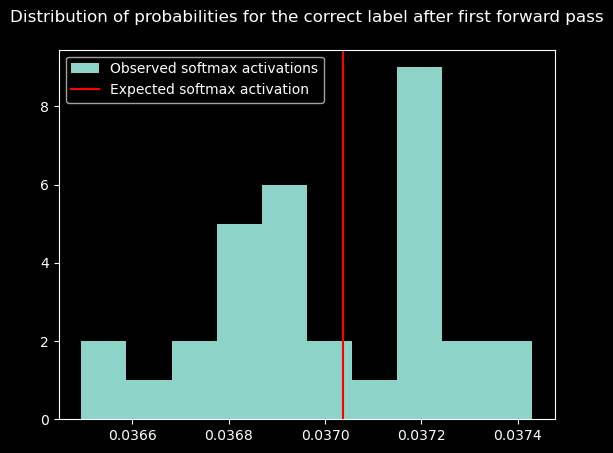

In [148]:
s = model_.introspector.third_layer_activations[list(range(len(batch_y))), batch_y]
plt.figure()
plt.title("Distribution of probabilities for the correct label after first forward pass", pad=20)
plt.hist(s.detach().numpy(), label='Observed softmax activations')
plt.axvline(x=1/len(all_symbols), color='r', label='Expected softmax activation')
plt.legend()
plt.show()

Activations with abs values > 0.95: 6.1%


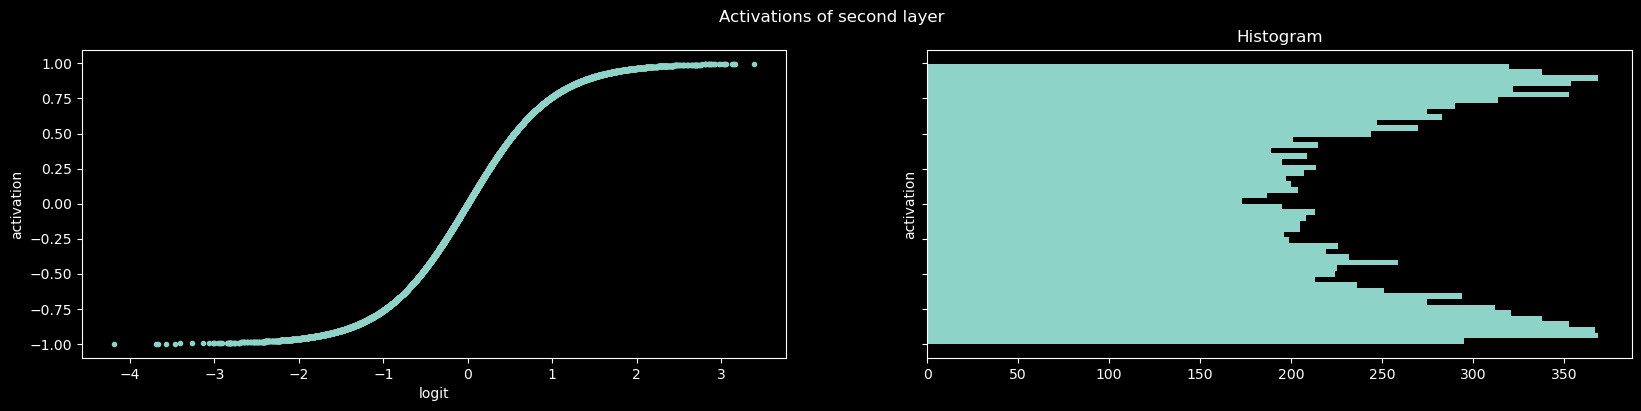

In [149]:
acts = model_.introspector.second_layer_activations.detach().numpy().reshape(-1)
print(f"Activations with abs values > 0.95: {(np.abs(acts) > 0.95).sum() / len(acts) * 100:.1f}%")

fig, ax = plt.subplots(1, 2, figsize=(20, 4), sharey=True)
fig.suptitle("Activations of second layer")
ax[0].scatter(np.arctanh(acts), acts, marker='.')
ax[0].set_xlabel('logit')
ax[0].set_ylabel('activation')
ax[1].set_title('Histogram')
ax[1].hist(acts, orientation='horizontal', bins=50)
ax[1].set_ylabel('activation')
plt.show()

### Differentiation of a cross-entropy of a single example with respect to the $j^{th}$ logit.
$w_t$-th logit corresponds to the true label

$$
L = log(p_{w_t})
$$
$$
L = log(p_{w_t}) = log(\frac{e^{y_{w_t}}}{\sum e^{y_i}})
$$

$$
\frac{\partial L}{\partial y_{w_t}} = \frac{1}{p_{w_t}} \cdot \frac{e^{y_{w_t}} (\sum e^{y_i}) - e^{2 y_{w_t}}}{(\sum e^{y_i})^2}
$$

$$
\frac{\partial L}{\partial y_{w_t}} = \frac{1}{p_{w_t}} \cdot (p_{w_t} - p_{w_t}^2) = 1 - p_{w_t}
$$

$$
\frac{\partial L}{\partial y_{j}} = \frac{- e^{y_{j}}}{\sum e^{y_i}} = - p_j
$$